# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

* качество предсказания;
* скорость предсказания;
* время обучения.

---

**Инструкция по выполнению проекта**

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

* Загрузите и подготовьте данные.
* Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
* Проанализируйте скорость работы и качество моделей.

***Примечания:***
* Для оценки качества моделей применяйте метрику RMSE.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
* Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
* Год выгрузки данных 2016.

---

**Описание данных**

Данные находятся в файле `/datasets/autos.csv`.

***Признаки***
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

***Целевой признак***
* `Price` — цена (евро)

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
import time

**Проанализируем данные на предмет дубликатов, пропусков, лишних признаков.**

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

---

In [5]:
# просмотр признаков с пропущенными значениями в процентном соотношении
df.isna().mean().sort_values(ascending=False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [6]:
# создание списка признаков с пропусками
t = df.isna().mean().sort_values(ascending=False)
columns_with_nan = list(t[t > 0].index)

In [7]:
columns_with_nan

['NotRepaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']

In [8]:
df[columns_with_nan].dtypes

NotRepaired    object
VehicleType    object
FuelType       object
Gearbox        object
Model          object
dtype: object

**Все признаки с пропущенными значениями имеют тип `object`. Принято решение заполнить все пропуски строкой: `no_info`.**

In [9]:
df = df.fillna('no_info')

In [10]:
# поиск дубликатов
df.duplicated().sum()

4

**Найдено `4шт.` явных дубликатов, удалим данные строки.**

In [11]:
df = df.drop_duplicates().reset_index(drop=True) 

**Признаки `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`, `RegistrationMonth` не несут значимо важной информации и никак не помогут в обучении моделей, принято решение их удалить.**

In [12]:
to_del = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth']
df = df.drop(to_del, axis=1)

---

**Разобьем параметр год регистрации авто на категории. Для этого создадим новый параметр `YearCategory`. Столетия разобьем на кварталы:**

* `20_I` - с 1900 по 1924, (двадцатый век, 1ая четверть)
* `20_II` - с 1925 по 1949, (двадцатый век, 2ая четверть)
* `20_III` - с 1950 по 1974, (двадцатый век, 3ья четверть)
* `20_IV` - с 1975 по 1999, (двадцатый век, 4ая четверть)
* `21_I` - с 2000, (двадцать первый век, 1ая четверть)

In [13]:
df['YearCategory'] = 'year'
df.loc[df['RegistrationYear'] < 1925, 'YearCategory'] = '20_I'
df.loc[(df['RegistrationYear'] >= 1925) & (df['RegistrationYear'] < 1950), 'YearCategory'] = '20_II'
df.loc[(df['RegistrationYear'] >= 1950) & (df['RegistrationYear'] < 1975), 'YearCategory'] = '20_III'
df.loc[(df['RegistrationYear'] >= 1975) & (df['RegistrationYear'] < 2000), 'YearCategory'] = '20_IV'
df.loc[df['RegistrationYear'] >= 2000, 'YearCategory'] = '21_I'

**Выделим обучающие признаки и целевой признак, а также разобьем данные на три части: `train` - для обучения, `valid` - валидационные и `test` - тестовые. Для этого используем метод `train_test_split` два раза.**

In [14]:
# обучающие признаки
features_100 = df.drop('Price', axis=1)

In [15]:
# целевой признак
target_100 = df['Price']

In [16]:
features_40, features_train, target_40, target_train = train_test_split(
    features_100, target_100, test_size=0.60, random_state=777)

In [17]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_40, target_40, test_size=0.50, random_state=777)

In [18]:
print(f'Размер обучаемого набора: {len(features_train)}, доля всех данных: \
{round(len(features_train) / len(features_100), 2)}')

print(f'Размер набора валидации: {len(features_valid)}, доля всех данных: \
{round(len(features_valid) / len(features_100), 2)}')

print(f'Размер тестового набора: {len(features_test)}, доля всех данных: \
{round(len(features_test) / len(features_100), 2)}')

Размер обучаемого набора: 212619, доля всех данных: 0.6
Размер набора валидации: 70873, доля всех данных: 0.2
Размер тестового набора: 70873, доля всех данных: 0.2


**В итоге получаем:**
* `features_train`, `target_train` - обучающий набор, 60% всех данных.
* `features_valid`, `target_valid` - данные валидации, 20% всех данных.
* `features_test`, `target_test` - тестовый набор, 20% всех данных.

**На данном этапе сохраним копии выборок для обучения моделей `catboost`, `lgbm` в дальнешем.**

In [19]:
# для catboost сохраним фичи\таргет набора train, признаки валидации\теста
features_train_cat, target_train_cat = features_train.copy(), target_train.copy()
features_valid_cat = features_valid.copy()
features_test_cat = features_test.copy()

# для LGBD сохраним исходный формат фичей train\valid\test
features_train_lgbm = features_train.copy()
features_valid_lgbm = features_valid.copy()
features_test_lgbm = features_test.copy()

---

In [20]:
# просмотр инфо по количественным признакам
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


**Из представленной информации определены некорретные значения в параметрах:**

* год регистрации авто - некорректные значения `min`, `max`.
* стоимость авто - некорректные значения `min`.

---

**Построим диаграмму размаха для параметра года регистрации.**

In [21]:
# настройка размера для всех графиков.
matplotlib.rcParams["figure.figsize"] = (15, 3)

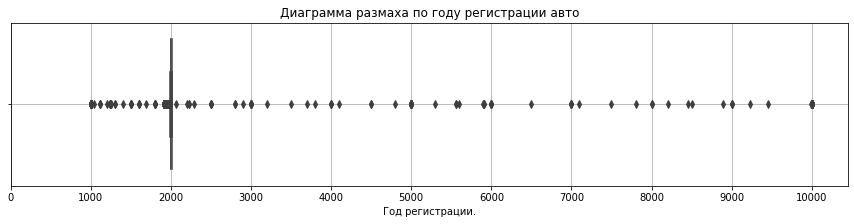

In [22]:
# строим диаграмму размаха года регистрации авто
plt.title('Диаграмма размаха по году регистрации авто')
sns.boxplot(x="RegistrationYear", data=df)
plt.xticks(np.arange(0, 11000, 1000))
plt.xlabel('Год регистрации.')
plt.grid()

**На графике заметны некорректные значения в виде выбросов попробуем сузить интервал графика от `1900` до `2025` года.**

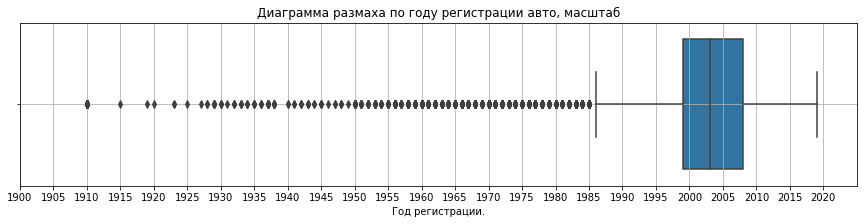

In [23]:
plt.title('Диаграмма размаха по году регистрации авто, масштаб')
sns.boxplot(x="RegistrationYear", data=df)
plt.xlim(1900, 2025)
plt.xticks(np.arange(1900, 2025, 5))
plt.xlabel('Год регистрации.')
plt.grid()

**Посчитаем кол-во объявлений с авто `< 1900г.` и `> 2020г.` регистрации в общем датафрейме и на трейне.**

In [24]:
# общий датафрейм
df[(df['RegistrationYear'] < 1900) | 
               (df['RegistrationYear'] > 2016)]['RegistrationYear'].count()

14596

In [25]:
# трэйн
features_train[(features_train['RegistrationYear'] < 1900) | 
               (features_train['RegistrationYear'] > 2016)]['RegistrationYear'].count()

8684

**Принято решение удалить строки из набора `train` с некорректным годом выпуска `< 1900г.` и `> 2020г.`, а после удалить сам признак `RegistrationYear`. 2016 - год выгрузки данных, поэтому используется данный год в качестве порога**

In [26]:
features_train = features_train[(features_train['RegistrationYear'] > 1900) & 
                                (features_train['RegistrationYear'] < 2016)]

In [27]:
# удаление признака RegistrationYear
features_train = features_train.drop('RegistrationYear', axis=1)
features_valid = features_valid.drop('RegistrationYear', axis=1)
features_test = features_test.drop('RegistrationYear', axis=1)

Синхронизация таргета

In [28]:
target_train = features_train.join(target_train)['Price']

In [29]:
# проверка
len(features_train) == len(target_train)

True

---

**Построим диаграмму размаха по стоимости авто, то есть таргету задачи.**

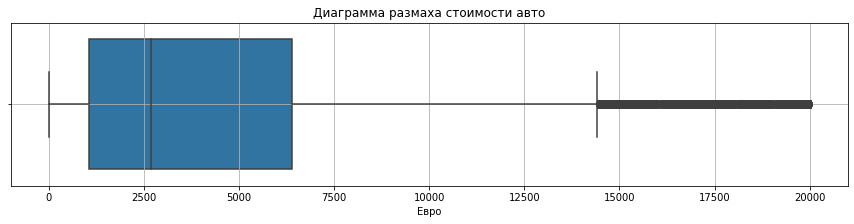

In [30]:
plt.title('Диаграмма размаха стоимости авто')
sns.boxplot(x="Price", data=df)
plt.xlabel('Евро')
plt.grid()

**Детальней взглянем на график в диапазоне около `0` евро.**

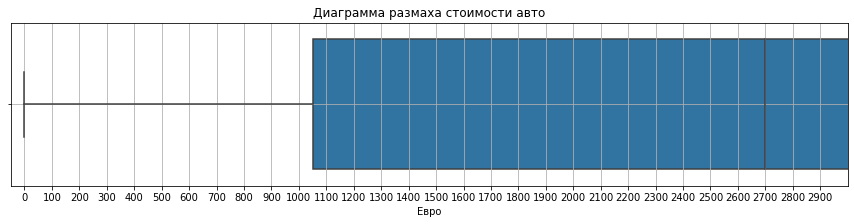

In [31]:
plt.title('Диаграмма размаха стоимости авто')
sns.boxplot(x="Price", data=df)
plt.xlim(-50, 3000)
plt.xticks(np.arange(0, 3000, 100))
plt.xlabel('Евро')
plt.grid()

**Посмотрим на значения - границы `95%` доверительного интервала.**

In [32]:
df['Price'].quantile(0.025)

0.0

In [33]:
df['Price'].quantile(0.975)

16900.0

**Посмотрим на кол-во строк со стоимостью авто `= 0`, `< 100`, а также `> 16900` евро на общем датафрейме и в наборе `train`.**

In [34]:
# общий датафрейм
df[df['Price'] == 0]['Price'].count()

10772

In [35]:
df[df['Price'] < 100]['Price'].count()

13314

In [36]:
df[df['Price'] > 16900.0]['Price'].count()

8606

In [37]:
# трейн

In [38]:
target_train[target_train == 0].count()

5624

In [39]:
target_train[target_train < 100].count()

7002

In [40]:
target_train[target_train > 16900].count()

5032

**Около `11 тыс.` объявлениий со стоимостью `0` евро в общем датафрейме, такие данные могут снизить качество моделей при предсказании.**

**Принято решение удалить строки со стоимостью `< 100` евро на трейне.**

In [41]:
target_train = target_train[target_train >= 100]

**Синхронизайция обучающих признаков**

In [42]:
features_train = features_train.join(target_train, how='right').drop('Price', axis=1)

In [43]:
# проверка
len(features_train) == len(target_train)

True

---

**Преобразуем категориальные признаки выборок в числовые с помощью метода `OneHotEncoder`.**

In [44]:
# выделение категориальных признаков
columns_cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'YearCategory']

In [45]:
# создание объекта OHE, обучение на категориальных признаках трейна.
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(features_train[columns_cat])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [46]:
# создание списка признаков, полученных в результате кодирования
columns_ohe = []
for column_ohe in ohe.categories_:
    for value_ohe in column_ohe:
        columns_ohe.append(value_ohe)

**Для преобразования категориальных признаков воспользуемся функцией:**

In [47]:
def ohe_transform(df):
    # создание массива данных
    array_values = ohe.transform(df[columns_cat])
    # преобразование в dataframe
    df_ohe = pd.DataFrame(data=array_values, columns=columns_ohe)
    # присваивание соответствующих индексов
    df_ohe.index = df.index
    # слияние датафреймов
    df = df.join(df_ohe)
    # удаление начальных категориальных признаков
    df = df.drop(columns_cat, axis=1)
    df.info()
    return df

In [48]:
features_train = ohe_transform(features_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191236 entries, 9626 to 59374
Columns: 321 entries, Power to 21_I
dtypes: float64(319), int64(2)
memory usage: 473.8 MB


In [49]:
features_valid = ohe_transform(features_valid)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70873 entries, 93496 to 20784
Columns: 321 entries, Power to 21_I
dtypes: float64(319), int64(2)
memory usage: 176.1 MB


In [50]:
features_test = ohe_transform(features_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70873 entries, 260401 to 117495
Columns: 321 entries, Power to 21_I
dtypes: float64(319), int64(2)
memory usage: 176.1 MB


**Вывод**

**Данные предобработаны, исследованы, подготовлены к обучению моделей.** 

**Для набров фичей удалены признаки `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`, `RegistrationMonth` т.к. не несут в себе значимой для обучения информации, признак `RegistrationYear` переведен в категориальный с разбивкой по кварталам.**

**Категориальные признаки `'VehicleType'`, `'Gearbox'`, `'Model'`, `'FuelType'`, `'Brand'`, `'NotRepaired'`, `'YearCategory'` преобразованы в числовые средствами `OneHotEncoder`.**

## Обучение моделей

**Перед обучением моделей посчитаем показатель метрики `RMSE` константной модели линейной регрессии на валидационной выборке. Константной принята модель, которая предсказывает среднее значение во всех случаях.**

In [51]:
const_predict = pd.Series(target_valid.mean(), index=target_valid.index)
const_rmse = mean_squared_error(target_valid, const_predict) ** 0.5

In [52]:
print("RMSE константной модели линейной регрессии на валидационной выборке:", const_rmse)

RMSE константной модели линейной регрессии на валидационной выборке: 4524.680621800304


### LinearRegression

In [53]:
model_lr = LinearRegression()

In [54]:
start_time = time.time()

model_lr.fit(features_train, target_train)

lr_time_fit = round(time.time() - start_time, 2)

In [55]:
%%time
predicted_valid = model_lr.predict(features_valid)

CPU times: user 106 ms, sys: 63.5 ms, total: 169 ms
Wall time: 202 ms


In [56]:
rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
print("RMSE модели линейной регрессии на валидационной выборке:", rmse)

RMSE модели линейной регрессии на валидационной выборке: 3023.4929137101167


### Decision Tree

**Для модели `Decision Tree` переберем гиперпараметр `max-depth` с целью определения лучшего.**

In [57]:
best_model_tree = None
best_rmse_tree = const_rmse

for depth_tree in range(1, 30):
    model_tree = DecisionTreeRegressor(random_state=777, max_depth=depth_tree)
    model_tree.fit(features_train, target_train)
    predicted_valid = model_tree.predict(features_valid)
    rmse = mean_squared_error(target_valid, predicted_valid) ** 0.5
    print(f'RMSE: {rmse}, глубина: {depth_tree}')
    if rmse < best_rmse_tree:
        best_model_tree = model_tree
        best_rmse_tree = rmse
        best_depth_tree = depth_tree
        
print(f'Лучшая модель решающего дерева, RMSE: {best_rmse_tree}, глубина: {best_depth_tree}')

Результат предыдущей ячейки:

Лучшая модель решающего дерева, RMSE: 2387.9916844696068, глубина: 19

---

**Теперь обучим модель с лучшими параметрами, выполним предсказание на валидационных данных.**

In [58]:
best_model_tree = DecisionTreeRegressor(random_state=777, max_depth=19)

In [59]:
start_time = time.time()

best_model_tree.fit(features_train, target_train)

tree_time_fit = round(time.time() - start_time, 2)

In [60]:
%%time
predicted_valid_tree = best_model_tree.predict(features_valid)

CPU times: user 104 ms, sys: 82.6 ms, total: 187 ms
Wall time: 191 ms


In [61]:
best_rmse_tree = mean_squared_error(target_valid, predicted_valid_tree) ** 0.5
print(f'Лучшая модель решающего дерева, RMSE: {best_rmse_tree}, глубина: 19')

Лучшая модель решающего дерева, RMSE: 2399.866706012182, глубина: 19


---

### Random forest

**С целью улучшения качества для модели случайного леса попробуем перебрать гиперпараметры кол-ва деревьев и глубины. Отталкиваться будем от значения `RMSE` константной модели.**

In [62]:
# запускать нежно ^_^

best_model_forest = None
best_rmse_forest = const_rmse

for depth in range(1, 30, 1):
    for est in range(1, 101, 10):
        model_forest = RandomForestRegressor(random_state=777, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predicted_valid = model_forest.predict(features_valid)
        rmse_forest = mean_squared_error(target_valid, predicted_valid) ** 0.5
        print(f'RMSE: {rmse_forest} кол-во деревьев: {est}, глубина: {depth}')
        if rmse_forest < best_rmse_forest:
            best_rmse_forest = rmse_forest
            best_est = est
            best_depth = depth
            best_model_forest = model_forest

print(f'Лучшая модель случайного леса: RMSE: {best_rmse_forest} \
                                    кол-во деревьев: {best_est}, глубина: {best_depth}') 

Результат предыдущей ячейки:

Лучшая модель случайного леса: RMSE: 2117.0100341060606 кол-во деревьев: 100, глубина: 30

---

**В результате перебора параметров случайного леса были зафиксированы лучшие со значениями кол-во деревьев: `185`, глубина: `35`. Обучим модель случайного леса с данными параметрами.**

In [63]:
best_model_forest = RandomForestRegressor(random_state=777, n_estimators=100, max_depth=30)

In [64]:
start_time = time.time()

best_model_forest.fit(features_train, target_train)

forest_time_fit = round(time.time() - start_time, 2)

In [65]:
%%time
predicted_valid_forest = best_model_forest.predict(features_valid)

CPU times: user 3.11 s, sys: 99.8 ms, total: 3.21 s
Wall time: 3.21 s


In [66]:
best_rmse_forest = mean_squared_error(target_valid, predicted_valid_forest) ** 0.5
print(f'Лучшая модель случайного леса, RMSE: {best_rmse_forest}, глубина: 35, кол-во деревьев: 185.')

Лучшая модель случайного леса, RMSE: 2127.622681079709, глубина: 35, кол-во деревьев: 185.


---

**Выделим наиболее важные признаки из модели `Random Forest`, для этого восспользуемся методом `feature_importances_`.**

Text(0, 0.5, 'Mean decrease in impurity')

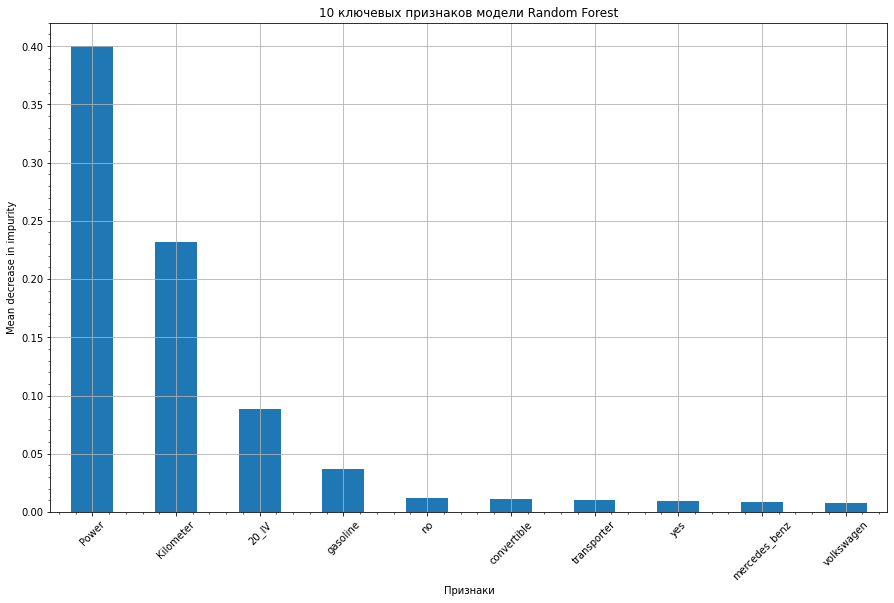

In [67]:
importances = best_model_forest.feature_importances_
feature_names = list(features_train.columns)

forest_importances = pd.Series(importances, index=feature_names)

# настройка размера для всех графиков.
matplotlib.rcParams["figure.figsize"] = (15, 9)

plt.title("10 ключевых признаков модели Random Forest")
forest_importances.sort_values(ascending=False)[:10].plot.bar(grid=True)
plt.xticks(rotation=45)
plt.minorticks_on()
plt.xlabel('Признаки')
plt.ylabel('Mean decrease in impurity')
# plt.tight_layout()

### Catboost

**Для модели `catboost` будем использовать заготовленные датасеты, сохраненные после разбиения на `train\valid\test`, в них заполнены пропуски, но все данные на трейне сохранены в исходном виде. Для данной модели необходимо выделить и указать категориальные признаки, а также передать валидационный набор в параметре `eval_set`.**

In [68]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'YearCategory']

In [69]:
model_catboost = CatBoostRegressor(loss_function='RMSE', 
                                   iterations=1000,
                                   learning_rate = 0.5,
                                   random_state=777)

In [70]:
start_time = time.time()

model_catboost.fit(features_train_cat, target_train_cat, 
                   cat_features=cat_features,
                   verbose=100,
                   eval_set=(features_valid_cat, target_valid))

catboost_time_fit = round(time.time() - start_time, 2)

0:	learn: 3265.9813153	test: 3263.0392462	best: 3263.0392462 (0)	total: 534ms	remaining: 8m 53s
100:	learn: 1771.1479805	test: 1819.5744865	best: 1819.5120753 (99)	total: 32.9s	remaining: 4m 53s
200:	learn: 1707.1321858	test: 1793.3009185	best: 1792.7501520 (196)	total: 1m 5s	remaining: 4m 22s
300:	learn: 1665.3097737	test: 1781.4687968	best: 1781.4687968 (300)	total: 1m 38s	remaining: 3m 49s
400:	learn: 1636.2458710	test: 1772.7140655	best: 1772.5106814 (389)	total: 2m 13s	remaining: 3m 18s
500:	learn: 1612.8520612	test: 1767.1526766	best: 1767.1518889 (498)	total: 2m 47s	remaining: 2m 46s
600:	learn: 1590.7399885	test: 1763.0551464	best: 1762.1442956 (572)	total: 3m 20s	remaining: 2m 13s
700:	learn: 1572.3071915	test: 1758.8580215	best: 1758.8580215 (700)	total: 3m 52s	remaining: 1m 39s
800:	learn: 1556.5737915	test: 1758.9817121	best: 1758.2015372 (754)	total: 4m 25s	remaining: 1m 5s
900:	learn: 1542.4070705	test: 1757.0668274	best: 1757.0101991 (899)	total: 5m	remaining: 33s
999:	l

**В ходе подбора параметров установлен `learning_rate = 0.5` - скорость обучения, кол-во итераций по умолчанию `1000`, лучшая итерация - `988`. Результат `RMSE` на валидационной выборке: `1754.66573`.**

### lightGBM

**Для обучения `LGBM` модели категориальные признаки необходимо привести к типу `category`.**

In [71]:
features_train_lgbm = features_train_lgbm[cat_features].astype('category')
features_valid_lgbm = features_valid_lgbm[cat_features].astype('category')
features_test_lgbm = features_test_lgbm[cat_features].astype('category')

In [72]:
model_lgbm = LGBMRegressor(n_estimators=100,
                           learning_rate = 0.5,
                           random_state = 777)

In [73]:
start_time = time.time()

model_lgbm.fit(features_train_lgbm, 
              target_train_cat,
              verbose = 10,
              eval_set=[(features_valid_lgbm, target_valid)],
              eval_metric='RMSE')

lgbm_time_fit = round(time.time() - start_time, 2)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[10]	valid_0's rmse: 3120.49	valid_0's l2: 9.73744e+06
[20]	valid_0's rmse: 3103.09	valid_0's l2: 9.62919e+06
[30]	valid_0's rmse: 3093.5	valid_0's l2: 9.56976e+06
[40]	valid_0's rmse: 3087.14	valid_0's l2: 9.53042e+06
[50]	valid_0's rmse: 3086.32	valid_0's l2: 9.52539e+06
[60]	valid_0's rmse: 3083.86	valid_0's l2: 9.51017e+06
[70]	valid_0's rmse: 3081.85	valid_0's l2: 9.49778e+06
[80]	valid_0's rmse: 3081.02	valid_0's l2: 9.49266e+06
[90]	valid_0's rmse: 3080.26	valid_0's l2: 9.48803e+06
[100]	valid_0's rmse: 3078.72	valid_0's l2: 9.47851e+06


**Лучший результат `RMSE` на валидационной выборке: `3078.72`.**

## Анализ моделей

**Для анализа моделей воспользуемся функцией, в которую будем передавать `модель`, `тестовые данные`, `время обучения`, посчитаное ранее, а также, в теле функции будем фиксировать время исполнения предикта на тестовых данных.**

In [74]:
result = []
def test_model(model, features, target, time_fit):
    global result
    start_time = time.time()
    predicted = model.predict(features)
    time_pred = round(time.time() - start_time, 2)
    rmse = mean_squared_error(target, predicted) ** 0.5
    result.append([model.__class__.__name__, time_fit, time_pred, round(rmse, 2)])
    print(f'{model.__class__.__name__} RMSE на тестовых данных: {rmse}')

In [75]:
# линейная регрессия
test_model(model_lr, features_test, target_test, lr_time_fit)

LinearRegression RMSE на тестовых данных: 3020.4967872408793


In [76]:
# решающее дерево
test_model(best_model_tree, features_test, target_test, tree_time_fit)

DecisionTreeRegressor RMSE на тестовых данных: 2436.62265034674


In [77]:
# случайный лес
test_model(best_model_forest, features_test, target_test, forest_time_fit)

RandomForestRegressor RMSE на тестовых данных: 2141.0438530658503


In [78]:
# Catboost
test_model(model_catboost, features_test_cat, target_test, catboost_time_fit)

CatBoostRegressor RMSE на тестовых данных: 1749.3383831525284


In [79]:
# LightGBM
test_model(model_lgbm, features_test_lgbm, target_test, lgbm_time_fit)

LGBMRegressor RMSE на тестовых данных: 3061.7123733876397


In [80]:
# оформление результатов в таблицу
result = pd.DataFrame(result, columns=['name', 'time_fit', 'time_pred', 
                                       'rmse_score']).sort_values(['time_pred', 'time_fit', 'rmse_score'])

## Вывод

**В ходе исследования были рассмотрены\изучены\протестированы модели:**

* **LinearRegression.**
* **Decision Tree.**
* **Random Forest.**
* **Catboost.**
* **LightGBM.**

**Часть признаков удалены, т.к. не несут в себе какой-либо важной информации для обучения: 
`DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`, `RegistrationMonth`.**

**Признак `RegistrationYear` был переведен в категориальный и также удален.**

**Данные в трэйне для моделей Линейная регрессия, Решающее дерево, Случайный лес были предобработаны - удалены строки с некорректной стоимостью, годом регистрации авто. Данные для Catboost, LGBM остались нетронутыми, за исключением типов категориальных признаков для LGBM.**

**Рассмотрены ключевые признаки при обучении модели Random Forest, из них можно выделить наиболее важные:**
* `Мощность автомобиля`,
* `Пробег автомобиле`,
* `Признак года выпуска авто (IV квартал 21 века)`.

**Расчитанные характеристики моделей `тайминг обучения\тайминг предсказания на тесте\RMSE-метрика`** :

In [81]:
result

,name,time_fit,time_pred,rmse_score
0,LinearRegression,16.64,0.17,3020.50
1,DecisionTreeRegressor,5.76,0.34,2436.62
4,LGBMRegressor,105.98,0.45,3061.71
3,CatBoostRegressor,340.62,1.07,1749.34
2,RandomForestRegressor,421.42,3.34,2141.04


**Из полученных результатов, по времени обучения самой быстрой оказалась модель `LightGBM`, но качество оставляет желать лучшего. Быстрее всех тестовые данные предсказывает модель `DecisionTree`. По качесву безусловный лидер - модель `Catboost`, но обучение модели занимает значительное время.**

**Если расматривать все параметы в совакупности, то стоит обратить внимание на модель `DecisionTree`. Возможно при более детальном анализе\тюнинге с данной моделью можно получить лучшие результаты.**